In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, random_split
import numpy as np
import random
from sklearn.metrics import f1_score, recall_score
import matplotlib.pyplot as plt
import os
import json

In [2]:
# Set device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"device: {device}")

device: cuda:0


In [3]:
# Download and load the CIFAR-10 dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
train_set = datasets.CIFAR10(root='../data', train=True, download=True, transform=transform)
test_set = datasets.CIFAR10(root='../data', train=False, download=True, transform=transform)

# Split train data into train and validation
train_size = int(0.8 * len(train_set))
val_size = len(train_set) - train_size
train_dataset, val_dataset = random_split(train_set, [train_size, val_size])

batch_size = 1024
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
# Function to set a random seed for reproducibility
def set_seed(seed=None):
    if seed is None:
        seed = np.random.randint(0, 10000)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    return seed

In [5]:
# Function for validation
def validate(net, val_loader, criterion):
    total_loss = 0.0
    with torch.no_grad():
        for data in val_loader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = net(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
    return total_loss / len(val_loader)

In [6]:
# Function to calculate test error
def calculate_test_error(net, test_loader):
    net.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data in test_loader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    test_accuracy = 100 * correct / total
    return 100 - test_accuracy  # Test error

In [7]:
# Function for training
def train_model(net, train_loader, val_loader, test_loader, criterion, optimizer, epochs):
    train_losses = []
    val_losses = []
    test_errors = []
    for epoch in range(epochs):
        running_loss = 0.0
        for i, data in enumerate(train_loader, 0):
            inputs, labels = data[0].to(device), data[1].to(device)

            optimizer.zero_grad()

            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
        
        train_losses.append(running_loss / len(train_loader))
        val_loss = validate(net, val_loader, criterion)
        val_losses.append(val_loss)
        test_error = calculate_test_error(net, test_loader)
        test_errors.append(test_error)
        print(f'Epoch {epoch + 1}/{epochs}, Train Loss: {train_losses[-1]}, Validation Loss: {val_losses[-1]}, Test Error: {test_errors[-1]}')

    return train_losses, val_losses, test_errors

In [8]:
# Function to calculate accuracy, F1 score, and recall
def calculate_metrics(net, loader):
    net.eval()
    correct = 0
    total = 0
    all_labels = []
    all_predictions = []
    
    with torch.no_grad():
        for data in loader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    accuracy = 100 * correct / total
    f1 = f1_score(all_labels, all_predictions, average='weighted')
    recall = recall_score(all_labels, all_predictions, average='weighted')
    return accuracy, f1, recall

In [9]:
# ResNet-18 with SE block

# SE block
class SEBlock(nn.Module):
    def __init__(self, channel, reduction=16):
        super(SEBlock, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(channel, channel // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channel // reduction, channel, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y.expand_as(x)


def initialize_model(device):
    net = models.resnet18(weights=None)
    num_features = net.fc.in_features

    # Adding an SE block
    net.avgpool = nn.Sequential(net.avgpool, SEBlock(num_features))

    # Adjusting for 10 classes in CIFAR-10
    net.fc = torch.nn.Linear(num_features, 10)
    net = net.to(device)

    return net

In [10]:
def initialize_loss_function():
    return nn.CrossEntropyLoss()

In [11]:
import swats

def initialize_optimizer(model_params):
    return swats.SWATS(model_params)

Run: 1
Seed: 8000


c:\Users\sbp5911\AppData\Local\Programs\Python\Python311\Lib\site-packages\swats\optim.py:126: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at ..\torch\csrc\utils\python_arg_parser.cpp:1519.)
  exp_avg.mul_(beta1).add_(1 - beta1, grad)


Epoch 1/200, Train Loss: 1.4993932336568832, Validation Loss: 1.2904030442237855, Test Error: 51.67
Epoch 2/200, Train Loss: 2.4359718441963194, Validation Loss: 2.061528205871582, Test Error: 74.6
Epoch 3/200, Train Loss: 1.82272067964077, Validation Loss: 1.705334484577179, Test Error: 62.6
Epoch 4/200, Train Loss: 1.554288375377655, Validation Loss: 1.5964510560035705, Test Error: 57.33
Epoch 5/200, Train Loss: 1.4219201654195786, Validation Loss: 1.5223249673843384, Test Error: 55.74
Epoch 6/200, Train Loss: 1.3245364457368851, Validation Loss: 1.3279706716537476, Test Error: 48.25
Epoch 7/200, Train Loss: 1.240639975667, Validation Loss: 1.2498543381690979, Test Error: 44.89
Epoch 8/200, Train Loss: 1.1433389812707901, Validation Loss: 1.1989692568778991, Test Error: 43.51
Epoch 9/200, Train Loss: 1.0699594095349312, Validation Loss: 1.1641586661338805, Test Error: 41.19
Epoch 10/200, Train Loss: 1.0150474652647972, Validation Loss: 1.1005945444107055, Test Error: 39.04
Epoch 11/2

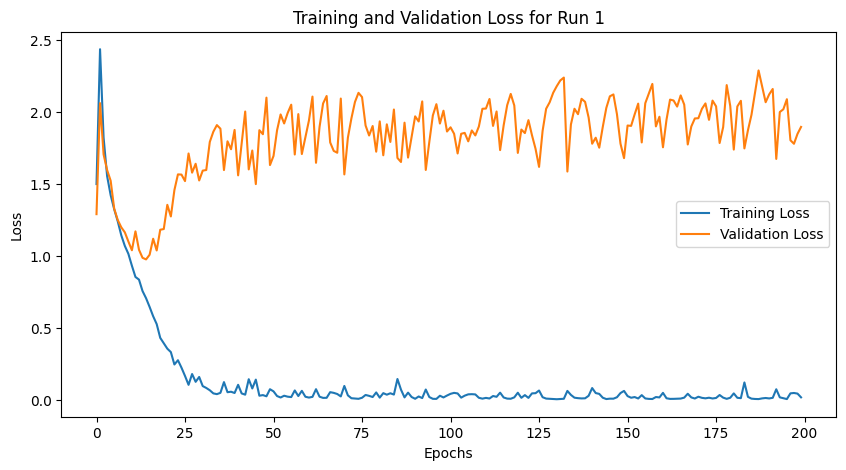

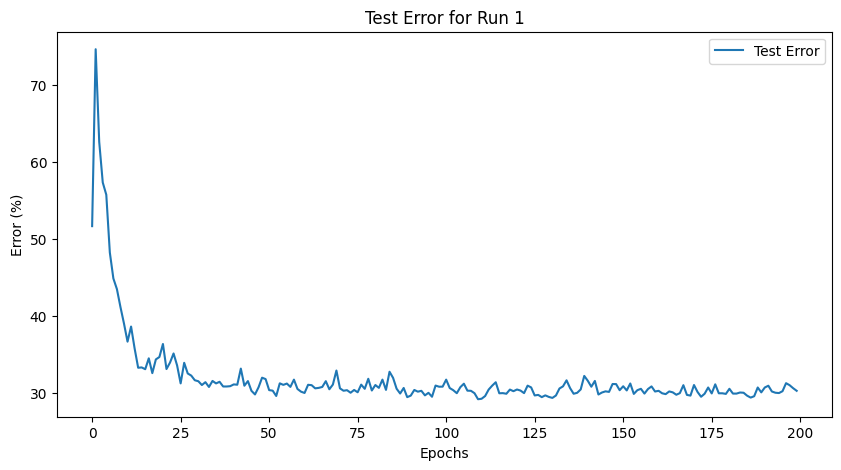

Run: 2
Seed: 236
Epoch 1/200, Train Loss: 1.483376568555832, Validation Loss: 1.2878103733062745, Test Error: 49.26
Epoch 2/200, Train Loss: 2.205409660935402, Validation Loss: 1.8310693979263306, Test Error: 68.78999999999999
Epoch 3/200, Train Loss: 1.731773030757904, Validation Loss: 1.7260931253433227, Test Error: 63.69
Epoch 4/200, Train Loss: 1.5391575664281845, Validation Loss: 1.9901557087898254, Test Error: 66.00999999999999
Epoch 5/200, Train Loss: 1.4358123958110809, Validation Loss: 1.706791615486145, Test Error: 59.78
Epoch 6/200, Train Loss: 1.3190432280302047, Validation Loss: 1.3591968774795533, Test Error: 48.94
Epoch 7/200, Train Loss: 1.1717493146657945, Validation Loss: 1.2709945440292358, Test Error: 45.99
Epoch 8/200, Train Loss: 1.0857170447707176, Validation Loss: 1.3135692000389099, Test Error: 45.63
Epoch 9/200, Train Loss: 1.0142013654112816, Validation Loss: 1.176536774635315, Test Error: 41.98
Epoch 10/200, Train Loss: 0.9172258675098419, Validation Loss: 1

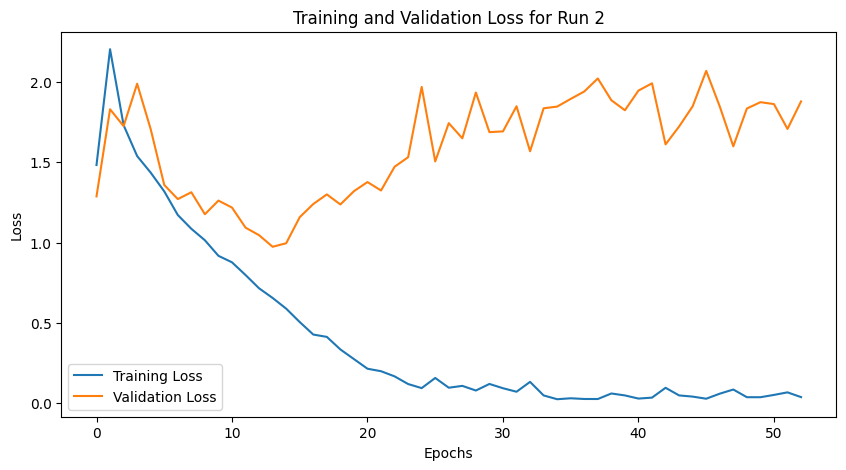

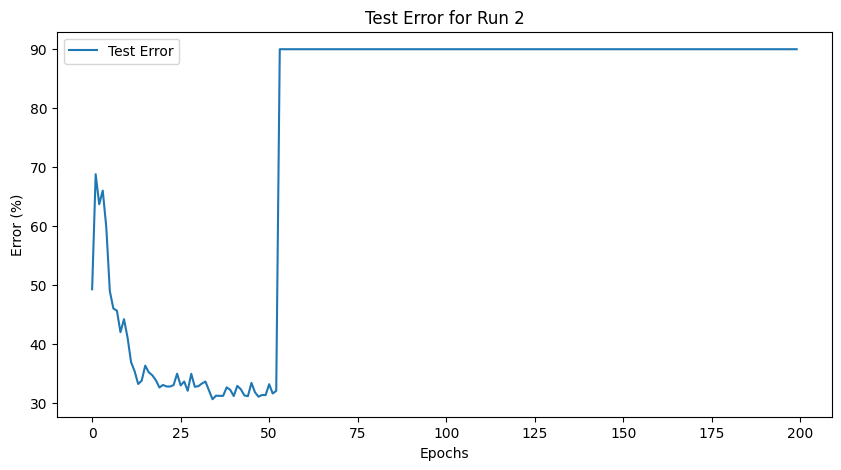

Run: 3
Seed: 897
Epoch 1/200, Train Loss: 1.465571364760399, Validation Loss: 1.3209059834480286, Test Error: 50.96
Epoch 2/200, Train Loss: 2.197800028324127, Validation Loss: 1.8302090287208557, Test Error: 69.52
Epoch 3/200, Train Loss: 1.6721996873617173, Validation Loss: 1.597054898738861, Test Error: 58.82
Epoch 4/200, Train Loss: 1.4690041482448577, Validation Loss: 1.6554122686386108, Test Error: 57.81
Epoch 5/200, Train Loss: 1.3399603635072708, Validation Loss: 1.3238219976425172, Test Error: 47.88
Epoch 6/200, Train Loss: 1.194647228717804, Validation Loss: 1.2075706481933595, Test Error: 43.39
Epoch 7/200, Train Loss: 1.1128410011529923, Validation Loss: 1.3036947131156922, Test Error: 44.88
Epoch 8/200, Train Loss: 1.046003919839859, Validation Loss: 1.0999869346618651, Test Error: 39.24
Epoch 9/200, Train Loss: 0.9447014078497886, Validation Loss: 1.0857658982276917, Test Error: 36.72
Epoch 10/200, Train Loss: 0.8497678205370903, Validation Loss: 1.0969224452972413, Test 

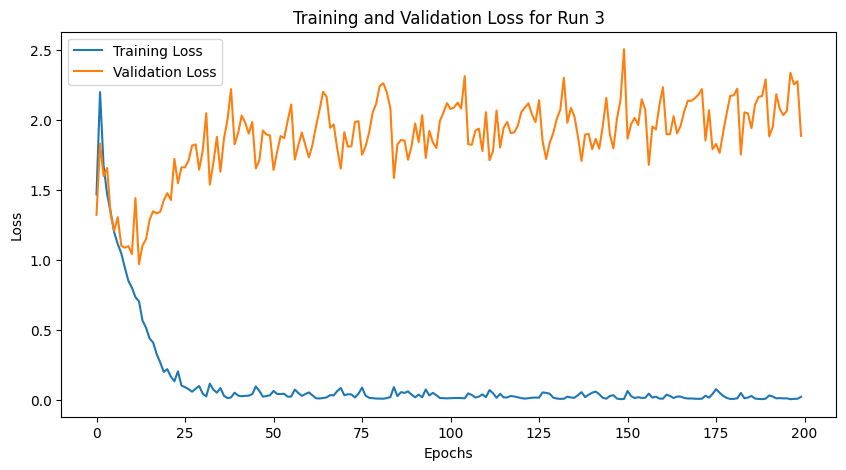

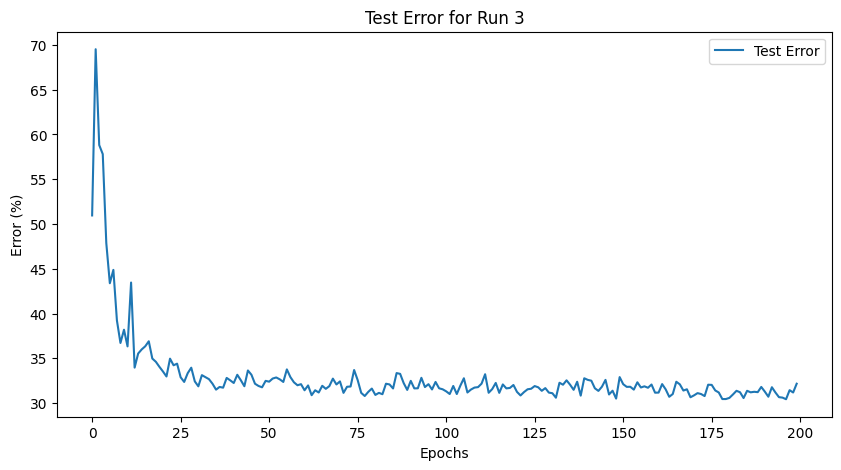

Run: 4
Seed: 3187
Epoch 1/200, Train Loss: 1.4760913044214248, Validation Loss: 1.2710642337799072, Test Error: 51.14
Epoch 2/200, Train Loss: 2.296692705154419, Validation Loss: 1.9579444766044616, Test Error: 75.39
Epoch 3/200, Train Loss: 1.7382481098175049, Validation Loss: 1.633059799671173, Test Error: 61.1
Epoch 4/200, Train Loss: 1.5550064742565155, Validation Loss: 1.7407147288322449, Test Error: 62.57
Epoch 5/200, Train Loss: 1.4276210755109786, Validation Loss: 1.45773743391037, Test Error: 52.75
Epoch 6/200, Train Loss: 1.2782388418912887, Validation Loss: 1.5852323293685913, Test Error: 55.15
Epoch 7/200, Train Loss: 1.2116132408380509, Validation Loss: 1.3177491426467896, Test Error: 46.62
Epoch 8/200, Train Loss: 1.1000521659851075, Validation Loss: 1.2006558299064636, Test Error: 43.28
Epoch 9/200, Train Loss: 1.026474294066429, Validation Loss: 1.301966667175293, Test Error: 45.04
Epoch 10/200, Train Loss: 0.9728591173887253, Validation Loss: 1.1439887642860413, Test E

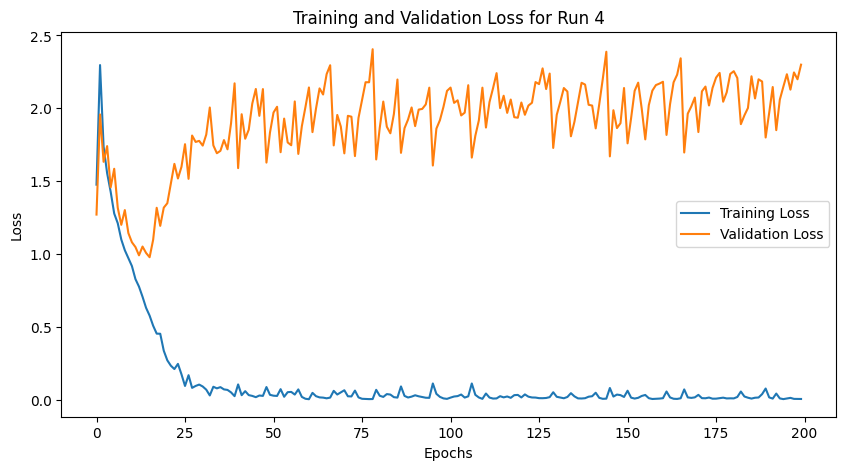

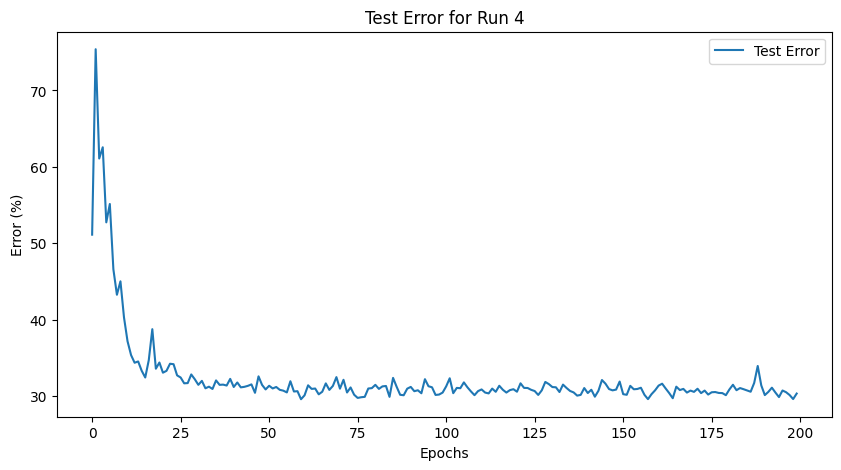

Run: 5
Seed: 1800
Epoch 1/200, Train Loss: 1.4871002078056335, Validation Loss: 1.2572645783424377, Test Error: 50.18
Epoch 2/200, Train Loss: 2.2603616237640383, Validation Loss: 1.8574946999549866, Test Error: 69.51
Epoch 3/200, Train Loss: 1.6535131722688674, Validation Loss: 1.5450869083404541, Test Error: 57.98
Epoch 4/200, Train Loss: 1.4227866858243943, Validation Loss: 1.4898748874664307, Test Error: 54.47
Epoch 5/200, Train Loss: 1.3233587145805359, Validation Loss: 1.3737716674804688, Test Error: 50.75
Epoch 6/200, Train Loss: 1.2291437894105912, Validation Loss: 1.238812220096588, Test Error: 44.5
Epoch 7/200, Train Loss: 1.1184252083301545, Validation Loss: 1.2748135685920716, Test Error: 45.3
Epoch 8/200, Train Loss: 1.0494421303272248, Validation Loss: 1.4030617237091065, Test Error: 45.98
Epoch 9/200, Train Loss: 0.9866672843694687, Validation Loss: 1.070001518726349, Test Error: 38.14
Epoch 10/200, Train Loss: 0.9029297053813934, Validation Loss: 1.033446490764618, Test

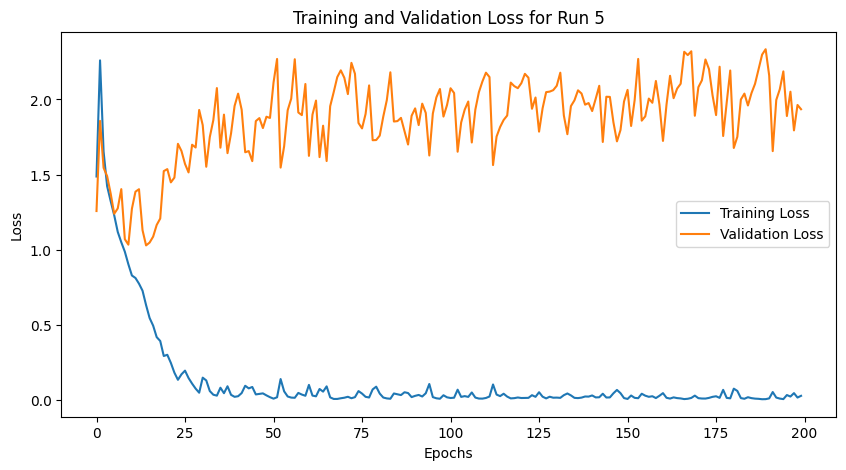

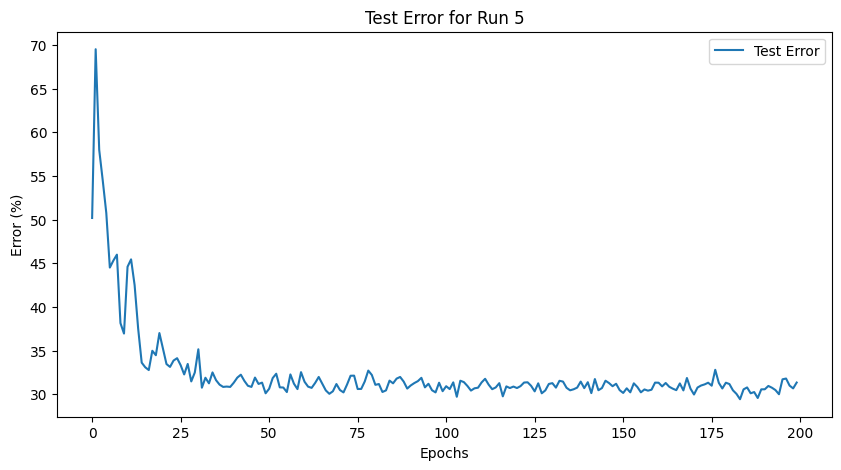

In [12]:
# Run the training for 5 different seeds
num_runs = 5
epochs = 200
metrics = {
    'seed': [],
    'train_losses': [],
    'val_losses': [],
    'test_errors': [],
    'val_accuracy': [],
    'val_f1': [],
    'val_recall': [],
    'test_accuracy': [],
    'test_f1': [],
    'test_recall': []
}



# Initialize dictionaries to store results
results = {
    'train_losses': [],
    'val_losses': [],
    'test_errors': []
}

for run in range(num_runs):
    print(f"Run: {run + 1}")
    seed = set_seed()
    print(f"Seed: {seed}")

    # Reinitialize the model, loss function, and optimizer
    net = initialize_model(device=device)
    criterion = initialize_loss_function()
    optimizer = initialize_optimizer(model_params=net.parameters())

    # Train the network
    train_losses, val_losses, test_errors = train_model(net, train_loader, val_loader, test_loader, criterion, optimizer, epochs)
    metrics['test_errors'].append(test_errors)

    # Calculate metrics on validation and test sets
    val_accuracy, val_f1, val_recall = calculate_metrics(net, val_loader)
    test_accuracy, test_f1, test_recall = calculate_metrics(net, test_loader)
    
    # Print metrics for validation set
    print(f"Run {run + 1} - Validation Metrics:")
    print(f"    Accuracy: {val_accuracy}%")
    print(f"    F1 Score: {val_f1}")
    print(f"    Recall:   {val_recall}")

    # Print metrics for test set
    print(f"Run {run + 1} - Test Metrics:")
    print(f"    Accuracy: {test_accuracy}%")
    print(f"    F1 Score: {test_f1}")
    print(f"    Recall:   {test_recall}")
    
    # Store metrics
    metrics['seed'].append(seed)
    metrics['train_losses'].append(train_losses)
    metrics['val_losses'].append(val_losses)
    metrics['val_accuracy'].append(val_accuracy)
    metrics['val_f1'].append(val_f1)
    metrics['val_recall'].append(val_recall)
    metrics['test_accuracy'].append(test_accuracy)
    metrics['test_f1'].append(test_f1)
    metrics['test_recall'].append(test_recall)
    
    # Append the results for the current run
    results['train_losses'].append(metrics['train_losses'][run])
    results['val_losses'].append(metrics['val_losses'][run])
    results['test_errors'].append(metrics['test_errors'][run])

    # Plot for training and validation loss
    plt.figure(figsize=(10, 5))
    plt.plot(metrics['train_losses'][run], label='Training Loss')
    plt.plot(metrics['val_losses'][run], label='Validation Loss')
    plt.title(f"Training and Validation Loss for Run {run+1}")
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # Plot for test error
    plt.figure(figsize=(10, 5))
    plt.plot(metrics['test_errors'][run], label='Test Error')
    plt.title(f"Test Error for Run {run+1}")
    plt.xlabel('Epochs')
    plt.ylabel('Error (%)')
    plt.legend()
    plt.show()

Mean Metrics: {'val_accuracy': 57.794, 'val_f1': 0.5620796501157777, 'val_recall': 0.57794, 'test_accuracy': 57.162, 'test_f1': 0.555583918799429, 'test_recall': 0.57162}
Standard Deviation of Metrics: {'val_accuracy': 23.989751645233845, 'val_f1': 0.2722687117792786, 'val_recall': 0.23989751645233845, 'test_accuracy': 23.59086721593761, 'test_f1': 0.2687734540497177, 'test_recall': 0.23590867215937614}


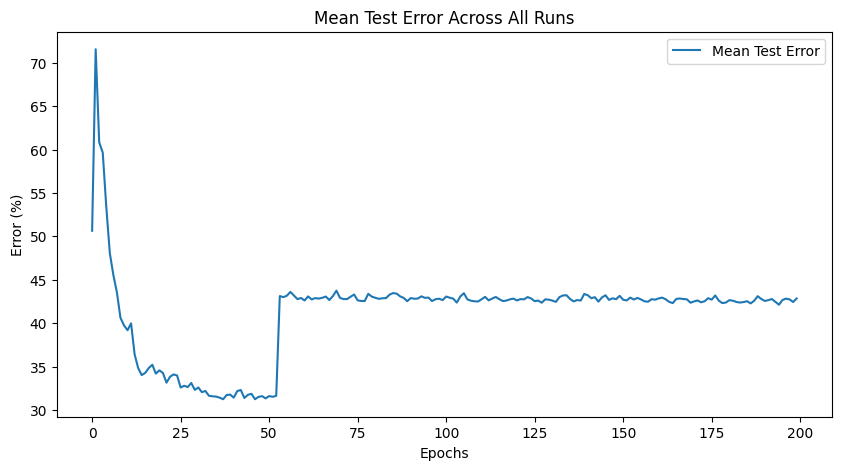

In [13]:
# Calculate mean and standard deviation across runs
mean_metrics = {metric: np.mean(metrics[metric]) for metric in metrics if metric not in ['seed', 'train_losses', 'val_losses', 'test_errors']}
std_metrics = {metric: np.std(metrics[metric]) for metric in metrics if metric not in ['seed', 'train_losses', 'val_losses', 'test_errors']}

# Print mean metrics and standard deviation
print("Mean Metrics:", mean_metrics)
print("Standard Deviation of Metrics:", std_metrics)

# Calculate mean test error across all runs
mean_test_errors = np.mean(metrics['test_errors'], axis=0)

# Plot mean test error
plt.figure(figsize=(10, 5))
plt.plot(mean_test_errors, label='Mean Test Error')
plt.title("Mean Test Error Across All Runs")
plt.xlabel('Epochs')
plt.ylabel('Error (%)')
plt.legend()
plt.show()

In [14]:
# Directory for saving results
save_dir = 'ResNet18_AL_Results'
os.makedirs(save_dir, exist_ok=True)

# Save the results to a file
with open(os.path.join(save_dir, 'SWATS.json'), 'w') as f:
    json.dump(results, f)